# GDPS 🅱

<style>
  .beta-badge {
    background-color: #f39c12;
    color: white;
    padding: 4px 8px;
    border-radius: 4px;
    font-weight: bold;
  }
</style>

<span class="beta-badge">BETA</span>
<span class="beta-badge">Requires MetPy >=1.6</span>

This demonstrates using data from Canada's GEM Global or Global Deterministic Prediction System (GDPS).

[GDPS Model Description](https://eccc-msc.github.io/open-data/msc-data/nwp_gdps/readme_gdps-datamart_en/#data-location)


**Data Sources**

|`prioriy=`|Data source| Archive Duration|
|--|--|--|
|`"mcs"` | [Meteorological Service of Canada](https://dd.weather.gc.ca/model_gem_global/) | Last 24 hours

**Model Initialization**

Model cyles every twelve hours.

**Forecast Hour**

For the most recent version of GDPS...

|`fxx=`|Forecast lead time|
|--|--|
|`0` through `240`, step=3| 3-hourly forecasts available


**Products**

|`product=`| Product Description |    
|--|--|
|`"15km/grib2/lat_lon"`| Global domain

**Variable and Level**

You will need to specify the variable and level for each request. 

<br>


> **NOTE:** The organization of these files is different than other NWP products.
>
> 1. There are no index files provided.
> 1. Each GRIB2 file only contains one message. The variable name and level is in the file's name.
>
> Herbie requires you provide a keyword argument for both `variable` and `level`. Pay special attention to model description (linked above) to understand how the model data is organized. If you don't provide input for `variable` or `level`, Herbie will give you some ideas. For example, `variable=TMP` and `level=TGL_2` will give you the filename that contains
>
> ```
> TMP_TGL_2
> ```

> **Note:** This requires MetPy version 1.6 or greater which has the capability to parse the _rotated latitude longitude_ map projection type (see [MetPy/#3123](https://github.com/Unidata/MetPy/pull/3123)).


In [1]:
from herbie import Herbie
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from toolbox import EasyMap, pc
import cartopy.crs as ccrs
import cartopy.feature as feature
import pandas as pd

from matplotlib.patches import Rectangle
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pytz


recent = pd.Timestamp("now").floor("12h")# - pd.Timedelta("12h")

 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ WARNING: Unable to create config file               │
 │      /Users/andrew/.config/herbie/config.toml        │
 │ Herbie will use standard default settings.           │
 │ Consider setting env variable HERBIE_CONFIG_PATH.    │
 ╰──────────────────────────────────────────────────────╯



## 500 hPa Geopotential Height and Surface Precipitation

In [2]:
# Get the necessary fields and parse into xarrays

store = []
ds = 0
# 500mb height, total cloud cover, precipitation rate
for var, lev in zip(["HGT", "TCDC", "PRATE"], ["ISBL_500", "SFC_0", "SFC_0"]):
    print(var, lev)
    _ds = Herbie(
        recent,
        model="gdps",
        fxx=240,
        variable=var,
        level=lev,
    ).xarray()
    
    # if the variable name is unknown, assign it
    if "unknown" in _ds:
        _ds = _ds.rename({"unknown":var})
    
    store.append(_ds)

ds = xr.merge(store)

HGT ISBL_500
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2024-Nov-18 12:00 UTC F240 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


TCDC SFC_0
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2024-Nov-18 12:00 UTC F240 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


PRATE SFC_0
✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2024-Nov-18 12:00 UTC F240 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


In [3]:
# slice out only the domain we care about
ds = ds.sel(longitude=slice(-195, -97), latitude=slice(30, 73))
ds["prate"] *= (3600 * 6) # convert from kg/m3/s to mm/6h
ds.prate.values.max()

np.float32(143.20801)

Text(0.35, 0.69, '500 mb\nHeight')

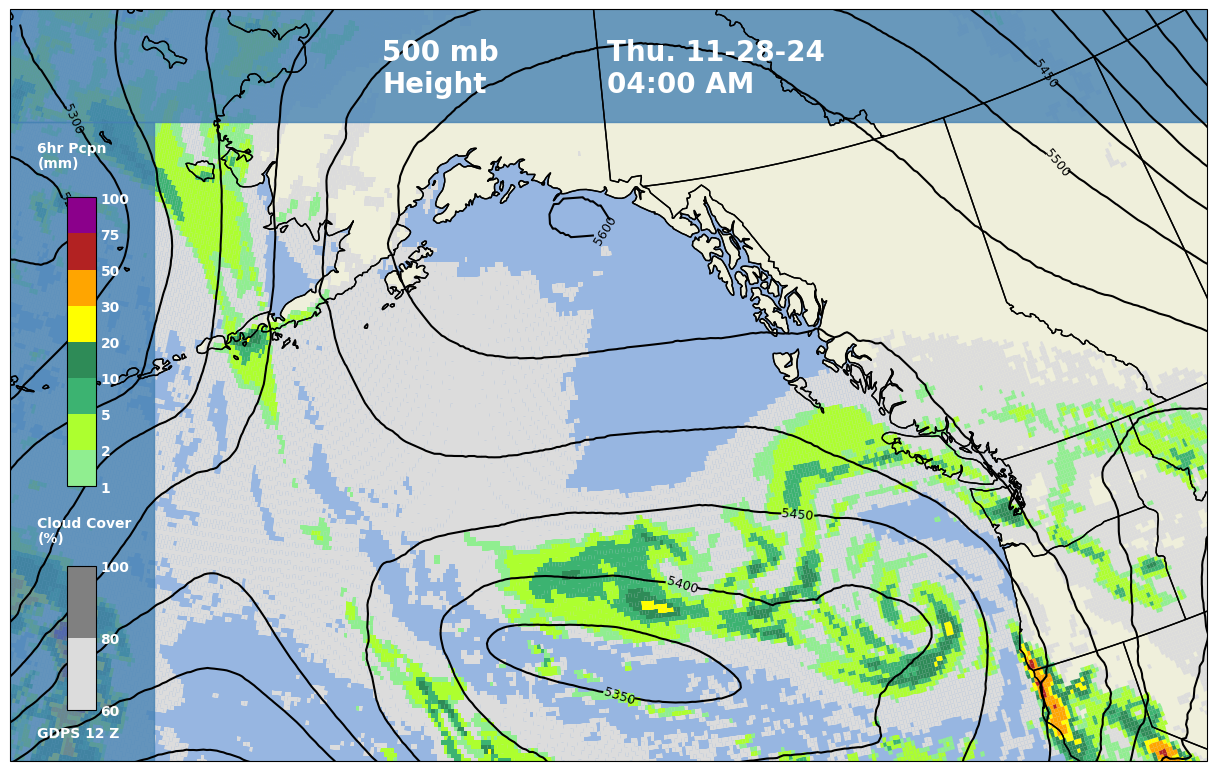

In [4]:
# make a figure
fig = plt.figure(figsize=(15,15))
fig.tight_layout()
ax = fig.add_subplot(1, 1, 1, 
                     position=(0,0,1,1), 
                     projection=ccrs.LambertConformal(central_longitude=-150, central_latitude=39.0,))
ax.set_extent([-170, -117, 40, 63])

# basemap
ax.add_feature(feature.LAND)
ax.add_feature(feature.STATES)
ax.add_feature(feature.OCEAN)
ax.add_feature(feature.COASTLINE)

# plot height contours
ht = ax.contour(
    ds.longitude,
    ds.latitude,
    ds.gh,
    colors="k",
    transform=pc,
    levels=range(0, 6000, 50),
)
ax.clabel(ht, inline=True, fontsize=9)

# plot cloud cover
cc_cmap = mpl.colors.ListedColormap(['#DCDCDC',
                                     '#808080'])
cc_bounds = [60, 80, 100]
cc_norm = mpl.colors.BoundaryNorm(cc_bounds, cc_cmap.N)
cc = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.prate.where(ds.TCDC >= 60),
    cmap=cc_cmap,
    norm=cc_norm,
    antialiased=True,
    transform=pc,
)

# plot precip rate
pr_cmap = mpl.colors.ListedColormap(['#90EE90',
                                     '#ADFF2F', 
                                     '#3CB371', 
                                     '#2E8B57', 
                                     '#FFFF00',
                                     '#FFA500', 
                                     '#B22222', 
                                     '#8B008B'])
pr_bounds = [1, 2, 5, 10, 20, 30, 50, 75, 100]
pr_norm = mpl.colors.BoundaryNorm(pr_bounds, pr_cmap.N)
pr = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.prate.where(ds.prate >= 1),
    cmap=pr_cmap,
    norm=pr_norm,
    antialiased=True,
    transform=pc,
)

# labels and such

# configure text to match AC style
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "heavy"

# shade out legend regions, AC style
ax.add_patch(Rectangle((0, 0), 0.12, 0.85, transform=ax.transAxes, color="steelblue", alpha=0.8))
ax.add_patch(Rectangle((0, 0.85), 1, 1, transform=ax.transAxes, color="steelblue", alpha=0.8))

# precip colorbar
fig.text(0.12, 0.65, "6hr Pcpn", color="white", size=10)
fig.text(0.12, 0.64, "(mm)", color="white", size=10)
pr_cbar = fig.colorbar(
                        pr,
                        cmap=pr_cmap, 
                        norm=pr_norm,
                        ax=ax,
                        spacing='uniform',
                        shrink=0.25,
                        location="left",
                        aspect=10,
                        anchor=(0.15,0.55),
                        pad=-0.15
                       )
pr_cbar.ax.tick_params(labelsize=10, 
                       labelcolor="white", 
                       length=0, 
                       labelright=True,
                       labelleft=False,
                      ) 

# cloud cover colorbar
fig.text(0.12, 0.40, "Cloud Cover", color="white", size=10)
fig.text(0.12, 0.39, "(%)", color="white", size=10)
cc_cbar = fig.colorbar(
                        cc,
                        cmap=cc_cmap, 
                        norm=cc_norm,
                        ax=ax,
                        spacing='uniform',
                        shrink=0.125,
                        location="left",
                        aspect=5,
                        anchor=(0.15,0.25),
                        pad=-0.18
                       )

cc_cbar.ax.tick_params(labelsize=10, 
                       labelcolor="white", 
                       length=0, 
                       labelright=True,
                       labelleft=False,
                      ) 

# timestamps
the_date = pd.Timestamp(ds.valid_time.values).tz_localize('UTC').tz_convert('America/Vancouver')
fmt_date = the_date.strftime('%a. %m-%d-%y \n%H:%M %p')
fig.text(0.5, 0.69, fmt_date, color="white", size=20)
fig.text(0.12, 0.26, f"{ds.model.upper()} {pd.Timestamp(ds.time.values).strftime("%H")} Z", color="white", size=10)

# title
fig.text(0.35, 0.69, '500 mb\nHeight', color="white", size=20)

